# 양자 키 분배

## 1. 소개

앨리스와 밥이 인터넷과 같은 안전하지 않은 비밀 메시지(예: 밥의 온라인 뱅킹 상세 정보)를 전달하려는 경우 메시지를 암호화는 것이 반드시 필요합니다. 암호학의 범위는 매우 넓고 대부분은 이 텍스트북의 범위를 벗어나기 때문에 앨리스와 밥이 아무도 모르는 비밀 키를 가지고 대칭 키 암호를 사용해서 통신할 수 있다고 믿어야 합니다.

앨리스와 밥이 이브의 고전 통신 채널을 사용해서 비밀 키를 공유하고자 한다면 이브가 직접 그 키의 복사본을 만들었는지 알 수가 없습니다. 앨리스와 밥은 전적으로 이브를 신뢰해야 합니다. 하지만 이브가 양자 통신 채널을 제공한다면 앨리스와 밥은 더이상 이브를 전적으로 신뢰할 필요가 없습니다. 앨리스와 밥은 이브가 메시지를 읽으려고 한다는 것을 알 수가 있습니다.

몇몇 독자에게는 물리적으로 양자 채널을 구현하는 아이디어가 유용할 수 있습니다. 고전 채널의 예제는 전화선이 있습니다. 메시지 또는 비트를 표현하는 라인을 통해서 전기 신호를 보냅니다. 제안하는 양자 통신 채널의 예제는 광섬유 케이블이 될 수도 있습니다. 이 때는 광자(빛의 입자)를 보냅니다. 광자는 *편광*이라 하는 속성이 있으며 편광은 두 가지 상태가 있습니다. 광자를 사용해서 큐비트를 표현할 수 있습니다.

## 2. 프로토콜 개요

프로토콜은 큐비트를 측정하면 상태가 변할 수 있다는 사실을 활용합니다. 앨리스가 밥에게 보낸 큐비트가 밥에게 닿기 전에 도청자(이브)가 측정하려 하면 큐비의 상태가 변하므로 밥은 앨리스가 보낸 큐비트 상태를 받을 수 없을 수도 있습니다. 

In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np

앨리스가 $|+\rangle$ ($X$ 기저로는 `0`) 상태의 큐비트를 보내고 밥이 $X$ 기저로 측정하면 `0` 상태를 얻을 수 있습니다.

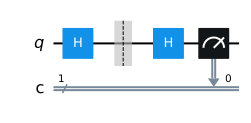

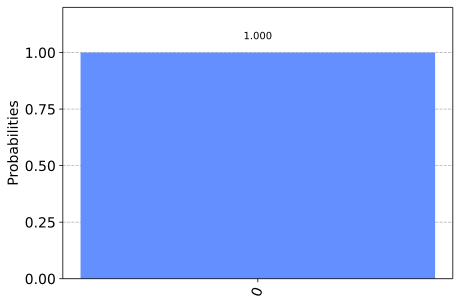

In [2]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

하지만 메시지가 밥에게 닿기 전에 이브가 이 큐비트를 $Z$ 기저로 측정하면 큐비트의 상태가 $|+\rangle$ 상태에서 $|0\rangle$ 또는 $|1\rangle$ 상태로 변하므로 밥은 더이상  `0` 을 측정할 수 없게 됩니다.

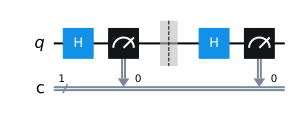

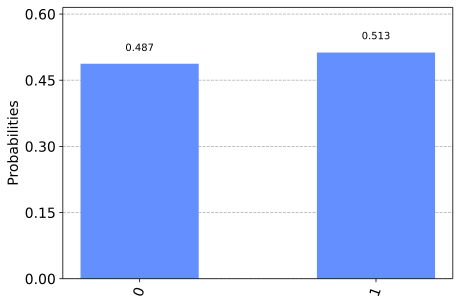

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

밥이 50%의 확률로 `1` 을 측정할 수 있으며, 그렇다면 밥과 앨리스는 채널에 문제가 있다는 것을 알게 됩니다.

양자 키 분배 프로토콜은 도청자가 거의 도청을 할 수 없게끔 이러한 과정을 충분히 반복하는 것을 포함합니다. 대략 다음과 같습니다.

**- 1 단계**

앨리스는 무작위 비트열을 선택합니다. 예를 들면 다음과 같습니다.

`1000101011010100`

그리고 각 비트의 기저를 무작위로 선택합니다.

`ZZXZXXXZXZXXXXXX`

엘리스는 이러한 2 가지 정보를 자기만 알도록 비밀로 유지합니다.

**- 2 단계**

앨리스는 선택한 기저를 사용해서 각 비트를 큐비트 문자열로 부호화 합니다. 이는 각 비트가 무작위로 선택된 $|0\rangle$, $|1\rangle$, $|+\rangle$, $|-\rangle$ 상태 중 하나가 됨을 의미합니다. 이 경우에 큐비트 문자열은 다음과 같습니다.

$$ |1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle|+\rangle|-\rangle|+\rangle|+\rangle $$

이것이 앨리스가 밥에게 보내는 메시지 입니다.

**- 3 단계**

밥은 무작위로 기저를 선택하여 각 큐비트를 측정합니다. 예를 들어 다음과 같은 기저를 사용할 수 있습니다.

`XZZZXZXZXZXZZZXZ`

그리고 밥은 측정한 결과를 비밀로 유지합니다.

**- 4 단계**

다음으로 밥과 앨리스는 각 큐비트에 사용한 기저를 공개적으로 공유합니다. 밥이 앨리스가 사용한 기저와 같은 기저로 큐비트를 측정했다면 측정값을 이용해 공유한 비밀키의 일부를 형성합니다. 그렇지 않으면 해당 비트의 정보를 버립니다.

**- 5 단계**

끝으로 밥과 앨리스는 키의 무작위 표본을 공유하고 만일 표본이 일치한다면 전송이 성공적임을 알 수 있습니다.


## 3. Qiskit 예제: 도청이 없는 경우

우선 아무도 듣고 있지 않을 때 프로토콜이 어떻게 동작하는지 살펴보고 앨리스와 밥이 어떻게 도청자를 탐지할 수 있는지 알아 봅시다. 항상 필요한 것을 import 하는 것부터 시작합니다.

numpy 에서 `randint` 함수를 사용하여 의사 무작위 키를 생성합니다. 이 페이지의 결과를 재현하려면 seed를 0으로 설정해야 합니다.

In [4]:
np.random.seed(seed=0)

앨리스의 초기 메시지 길이 `n`을 호출합니다. 이 예제에서 앨리스는 100 큐비트 길이의 메시지를 보냅니다.

In [5]:
n = 100

### 3.1 1 단계

앨리스는 무작위 비트 집합을 생성합니다.

In [6]:
np.random.seed(seed=0)
n = 100
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


앨리스만 비트 집합 '`alice_bits`' 을 알고 있습니다. 앨리스만 아는 정보가 무엇이고, 밥만 아는 정보가 무엇인지, 이브의 채널을 통해서 보낸 정보가 무엇인지 다음과 같은 표로 추적을 합니다.

앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |

### 3.2 2 단계

앨리스는 무작위로 $X$ 또는 $Z$ 기저에 있는 큐비트의 각 비트를 부호화 하도록 선택하고 각 큐비트의 선택을 `alice_bases` 에 저장합니다. 이 경우 `0` 는  "$Z$ 기저의 준비" 를 의미하고 `1` 는 "$X$ 기저의 준비"를 의미합니다.

In [7]:
np.random.seed(seed=0)
n = 100
## Step 1
#Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


앨리스는 이 정보를 비밀로 유지합니다.

앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |

아래 `encode_message` 함수는 `QuantumCircuit` 를 요소로 하는 리스트를 생성하고 각 양자 회로는 앨리스의 메시지에서 단일 큐비트를 나타냅니다.

In [8]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [9]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

`alices_bits` 에서 첫 번째 비트는 `0` 이고 부호화한 기저는 `1`로 표현하는 $X$ 기저 있음을 알 수 있습니다.

In [10]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 1


그리고 앨리스의 메시지에서 첫 번째 비트를 나타내는 `message` 에서 첫 번째 회로를 보면 앨리스가 $|+\rangle$ 상태의 큐비트를 준비한 것을 확인할 수 있습니다.

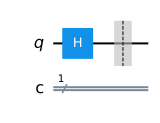

In [11]:
message[0].draw()

다른 예로 `alice_bits` 의 네 번째 비트는 `1` 이고 이 비트는 $Z$ 기저로 부호화 되었으며 앨리스는 $|1\rangle$ 상태인 큐비트를 준비한 것을 알 수 있습니다

bit = 1
basis = 0


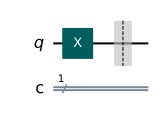

In [12]:
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw()

그런 다음 이 큐비트의 메시지는 이브의 채널을 통해 밥에게 전달됩니다.

앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message

### 3.3 3 단계

그리고 나서 밥은 각 큐비트를 무작위로 $X$ 또는 $Z$ 기저로 측정한 정보를 저장합니다.

In [13]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


밥은 각 큐비트를 측정할 때 사용한 기저를 `bob_bases` 에 저장합니다.

앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message
 |  | bob_bases

아래 함수 `measure_message` 는 측정을 위해 상응하는 양자 회로를 적용하고 시뮬레이션을 통해 각 큐비트를 측정한 결과를 `bob_results` 에 저장합니다.

In [14]:
def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        result = aer_sim.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [15]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

0 번째 큐비트를 의미하는 `message[0]` 의 회로는 밥이 선택한 $X$ 기저로 측정하는 것을 알 수 있습니다.

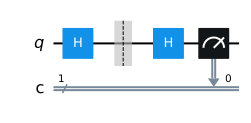

In [16]:
message[0].draw()

밥은 앨리스와 동일한 기저로 측정하기 때문에 밥은 결과 `0` 을 얻을 수 있었습니다. 아래 6 번째 큐비트는 밥이 앨리스와는 다른 기저를 무작위로 선택했기 때문에 밥과 앨리스의 결과가 일치할 확률은 50%에 불과합니다. 

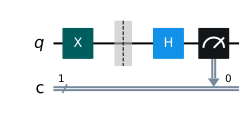

In [17]:
message[6].draw()

In [18]:
print(bob_results)

[0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]


밥은 이 결과를 비밀로 유지합니다.

앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message
 |  | bob_bases
 |  | bob_results

### 3.4 4 단계

이 후 앨리스는 이브의 채널을 통해 어떤 큐비트를 어떤 기저로 부호화했는지 공개합니다.

앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases

그리고 밥은 각 큐비트를 측정한 기저를 다음과 같이 공개합니다.

앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |

밥이 앨리스와 동일한 기저로 큐비트를 측정하면 이는 `bob_results` 의 항목이 상응하는 `alice_bits` 의 항목과 일치하고 해당 비트를 키의 일부로 사용할 수 있음을 의미합니다. 밥이 앨리스와는 다른 기저로 측정하면 밥의 결과는 무작위 이며 둘 다 해당 항목을 버립니다. 다음은 이 작업을 수행하는 `remove_garbage` 함수 입니다.

In [19]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

앨리스와 밥 모두 이 쓸모없는 비트를 버리고 남은 비트를 사용해서 비밀 키를 형성합니다.

In [20]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |
alice_key |  |  

In [21]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |
alice_key |  | bob_key

### 3.5 5 단계

끝으로 밥과 앨리스는 키에 있는 임의의 비트를 비교하여 프로토콜이 올바르게 작동하는지 확인합니다.

In [22]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

앨리스와 밥은 이를 공개적으로 알리고 더 이상 비밀이 아니므로 키에서 제거합니다.

In [23]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |
alice_key |  | bob_key
bob_sample | bob_sample | bob_sample
alice_sample | alice_sample | alice_sample

프로토콜이 감청 없이 올바르게 작동했다면 밥과 앨리스의 표본이 서로 일치해야 합니다.

In [24]:
bob_sample == alice_sample

True

밥과 앨리스의 표본이 일치하면 높은 확률로 `alice_key == bob_key` 를 의미합니다. 이제 밥과 앨리스는 메시지를 암호화하는 데 사용하는 비밀 키를 공유합니다.

앨리스의 정보 | 이브의 채널 | 밥의 정보
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
message | message | message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |
alice_key |  | bob_key
bob_sample | bob_sample | bob_sample
alice_sample | alice_sample | alice_sample
shared_key |  | shared_key

In [25]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
key length = 33


## 4. Qiskit 예제 *감청이 있는* 경우

이제 앨리스와 밥이 이브가 양자 메시지를 감청하려 했는지 알 수 있는 방법을 살펴보겠습니다. 감청이 없을 때와  동일한 단계를 반복하지만 밥이 큐비트를 받기 전에 이브는 큐비트에서 일부 정보를 감청하려할 수 있습니다. 재현 가능한 '무작위' 비트 집합 얻을 수 있도록 다른 seed를 설정해 보겠습니다.

In [26]:
np.random.seed(seed=3)

### 4.1 1 단계

앨리스는 무작위 비트 집합을 생성합니다.

In [27]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]


### 4.2 2 단계

앨리스는 이 비트를 무작위로 $Z$ 와 $X$ 기저로 부호화 하고 이브의 양자 채널을 통해 밥에게 보냅니다.

In [28]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


이 경우 앨리스 메시지의 첫 번째 큐비트는 $|+\rangle$ 상태입니다.

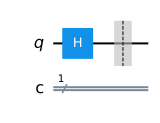

In [29]:
message[0].draw()

### 감청!

이브가 채널을 통과하는 메시지를 감청합니다. 이브는 기저를 무작위로 선택하여 큐비트를 측정합니다.

In [30]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


아래에서 큐비트 0의 경우를 볼 수 있습니다. 이브가 무작위로 선택하는 기저는 앨리스의 기저와 같지 않으며 이는 큐비트 상태를 $|+\rangle$ 에서 $Z$ 기저의 무작위 상태로 변화시키므로 50%의 확률로 $|0\rangle$ 또는 $|1\rangle$ 가 됩니다.

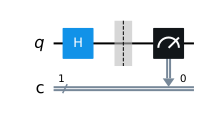

In [31]:
message[0].draw()

### 4.3 3 단계

그런 다음 이브는 큐비트를 무작위 기저로 측정하는 밥에게 큐비트를 전달합니다. 이 경우 밥은 우연히 앨리스가 준비한 것과 동일한 기저로 측정합니다. 감청이 없었으면 밥이 `0` 을 측정할 수 있지만 이브가 메시지를 읽으려했기 때문에 대신 `1` 을 측정할 확률이 50%가 됩니다.

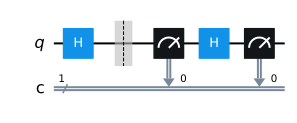

In [32]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
message[0].draw()

### 4.4 4 단계

밥과 앨리스는 기저를 공개하고 쓸모없는 비트를 버립니다.

In [33]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

### 4.5 5 단계

밥과 앨리스는 키의 동일한 무작위 선택을 비교하여 큐비트가 감청되었는지 확인합니다.

In [34]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [35]:
bob_sample == alice_sample

False

이런! 밥과 앨리스의 키가 일치하지 않습니다. 이브가 2 단계와 3 단계 사이의 메시지를 읽으려 시도하면서 큐비트의 상태가 변했기 때문입니다. 앨리스와 밥이 알고 있는 것처럼 이것은 채널의 잡음 때문일 수도 있지만 어느 쪽이든 모든 결과를 버리고 다시 시도해야 합니다. 이브의 감청은 실패했습니다.

## 5. 위험 분석

이브가 모든 큐비트를 측정하는 이러한 유형의 감청의 경우 밥과 앨리스의 표본이 일치할 가능성이 적으며 앨리스는 이브의 채널을 통해 취약한 메시지를 보냅니다. 그 확률을 계산하여 양자 키 분배가 얼마나 위험한지 살펴봅시다.

- 앨리스와 밥이 큐비트의 결과를 사용하려면 둘 다 같은 기저를 선택해야 합니다. 이브도 이 기저를 선택하면 오류 없이 성공적으로 이 비트를 감청할 것입니다. 이러 일이 발생할 확률은 50% 입니다.
- 이브가 *잘못된* 기저 즉, 앨리스와 밥과는 다른 기저를 선택하는 경우에도 밥이 앨리스가 보내려 했던 값을 측정할 확률은 여전히 50% 입니다. 이 경우 감청은 탐지되지 않습니다.
- 그러나 이브가 *잘못된* 기저 즉, 앨리스와 밥과는 다른 기저를 선택하는 경우에는 밥이 앨리스가 보내려 했던 값을 측정하지 못할 확률이 50% 이며 키에 오류가 발생할 것 입니다.

<img src="images/qkd_risk.svg">

앨리스와 밥이 키에서 1비트를 비교하면 비트가 일치할 확률은 $0.75$ 이며 그러면 앨리스와 밥은 이브의 감청을 알아차리지 못할 것입니다. 2 비트를 측정하면 감청이 탐지되지 않을 확률은 $0.75^2 = 0.5625$ 입니다. 이브가 탐지되지 않을 확률은 앨리스와 밥이 비교를 위해 선택한 비트 수 ($x$) 로 계산할 수 있습니다.

$$ P(\text{undetected}) = 0.75^x $$

위에서 했던 것처럼 15 비트를 비교하기로 했다면 이브가 탐지되지 않을 확률은 1.3% 입니다. 너무 위험하다면 50 비트를 비교할 수 있으며 확률은 0.00006% 가 됩니다.

아래 셀을 실행하여 프로토콜을 다시 시도할 수 있습니다. `sample_size`을 작은 값으로 변경하고 이브가 앨리스와 밥의 키를 감청하기 얼마나 쉬운지 확인하세요.

In [36]:
n = 100
# Step 1
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
# Step 2
message = encode_message(alice_bits, alice_bases)
# Interception!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
# Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
# Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
# Step 5
sample_size = 15 # Change this to something lower and see if 
                 # Eve can intercept the message without Alice
                 # and Bob finding out
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

Eve's interference was detected.


In [37]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/anaconda3/envs/terra-unstable/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
